In [1]:
%matplotlib inline
import pandas as pd
import pymysql as Mdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.4)

#### A convenience wrapper for executing an arbitrary query

In [2]:
def exec_query(query, server, schema):
    res_df = pd.DataFrame()
    
    port = 3306
    if server=="seaquel.physics.illinois.edu":
        port = 3283
    try:
        db = Mdb.connect(read_default_file='../.my.cnf',
                         read_default_group='guest',
                         host=server,
                         port=port,
                         db=schema)

        res_df = pd.read_sql(query, db)
        
        if db:
            db.close()

    except Mdb.Error, e:
        print "Error %d: %s" % (e.args[0], e.args[1])
    
    return res_df

#### What's the minimum and maximum runID with Hit data for R57?

In [3]:
server = "seaquel.physics.illinois.edu"

In [4]:
query = """
        SELECT MIN(run), MAX(run)
        FROM summary.production
        WHERE production LIKE '%R005' AND
            decoded=1 AND
            run BETWEEN 9045 AND 10420
        """
prod_df = exec_query(query, server, 'summary')
prod_df.head()

,MIN(run),MAX(run)
0,9079,10415


### Get intensity information from these runs, and one in between them

In [7]:
# Get intensity values for three roadsets:
#   at the beginning, middle, and end of Roadset 57
query = """
        SELECT eventID, Intensity, Intensity_p
        FROM QIE INNER JOIN Spill s USING(spillID)
        WHERE s.dataQuality=0 AND
            Intensity_p BETWEEN 10 AND 140000
        """
intensity_df1 = exec_query(query, server, 'run_009079_R005')
intensity_df2 = exec_query(query, server, 'run_009777_R005')
intensity_df3 = exec_query(query, server, 'run_010415_R005')

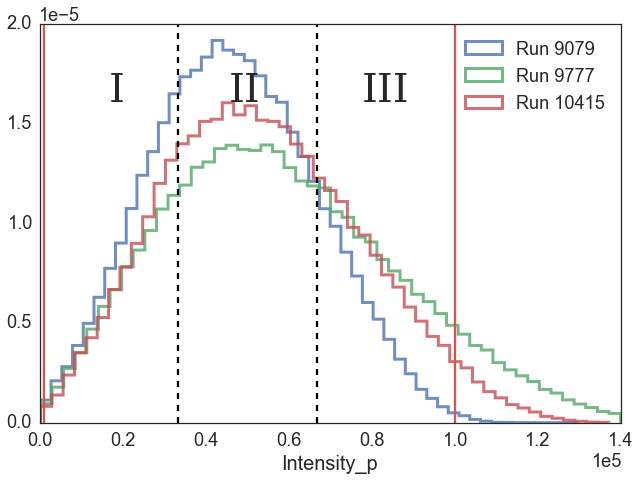

In [6]:
# Plot intensity distributions for three runs of Roadset 57
sns.distplot(intensity_df1['Intensity_p'], kde=False, norm_hist=True,
             label="Run 9079", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
sns.distplot(intensity_df2['Intensity_p'], kde=False, norm_hist=True,
             label="Run 9777", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
sns.distplot(intensity_df3['Intensity_p'], kde=False, norm_hist=True,
                  label="Run 10415", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
plt.legend(loc='best')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Plot intensity region dividers
c1 = sns.xkcd_rgb['pale red']
plt.vlines(1000, 0, 2e-5, color=c1, linestyles='-')
plt.vlines(33333, 0, 2e-5,  color='black', linestyles='--')
plt.vlines(66666, 0, 2e-5, color='black', linestyles='--')
plt.vlines(100000, 0, 2e-5, color=c1, linestyles='-')
plt.ylim([0,2e-5])

# Label regions
plt.text(17000, 1.61e-5, "I", size=40, fontdict={'family': 'serif'})
plt.text(46000, 1.61e-5, "II", size=40, fontdict={'family': 'serif'})
plt.text(78000, 1.61e-5, "III", size=40, fontdict={'family': 'serif'})

## Investigate Intensity-Dependence of Wire Maps

Kei has shown that detectors become inefficient in high-rate regions
<img src="figures/d1vp.png">

We hope to show that this inefficiency is not intensity-dependent.

To do so, we will show the wire maps of an inefficient detector plane for three intensity regions. If the wire map distribution changes depending on intensity region, then we have a problem.

In [5]:
# A function for plotting three wire maps for a given detector
def wiremap(df_list, ranges, run, detector, normed=True, kHit=False):
    roman_list = ['I', 'II', 'III', 'IV', 'V']
    bins = 0
    for df in df_list:
        if df.elementID.max() > bins:
            bins = df.elementID.max()
    for df, int_range, roman in zip(df_list, ranges, roman_list):
        df.elementID.hist(bins=bins,
                          range=(0, bins+1),
                          histtype='step',
                          lw=2, 
                          normed=normed,
                          label=("$I_p$ (%s)" % #: [%d, %d]" % 
                                 (roman)))#, int_range[0], int_range[1])))
        
    ax = plt.gca()
    ax.relim()
    ax.autoscale()
    plt.legend(loc='best')
    plt.xlim([0,bins])
    plt.xlabel('elementID')
    if kHit:
        plt.title("kHit %s: %s" % (run, detector))
        filename = ("figures/%s_%s_kHit" % (run, detector))
    else:
        plt.title("%s: %s" % (run, detector))
        filename = ("figures/%s_%s_Hit" % (run, detector))
    if normed:
        plt.yticks(visible=False)
        filename += "_norm"
    filename += ".eps"
    
    plt.savefig(filename)
    
    plt.show()
    
    return None

In [6]:
def wiremap_var_int(run, server, detector, ranges,
                    from_db=False, normed=True):
    # Fetch elementID's for a given intensity region
    # and a given detector
    
    df_list = []
    if from_db:
        query = """
            SELECT eventID, elementID, Intensity_p
            FROM %s.Hit INNER JOIN QIE USING(eventID)
            WHERE detectorName='%s' AND inTime=1
            """
        # Read out from DB and write to file
        df = exec_query(query % (run, detector), server, run)
        df.to_csv('data/%s_%s.csv' % (run, detector))
    else:
        try:
            df = pd.read_csv('data/%s_%s.csv' % 
                             (run, detector),
                             index_col='Unnamed: 0')
        except:
            print "Files may not exist. Aborting..."
            return None
        
    for int_range in ranges:
        df_list.append(df.query('Intensity_p >= @int_range[0] and '
                                'Intensity_p < @int_range[1]').copy())
    
    wiremap(df_list, ranges, run, detector, normed=normed)
    
    return None

In [8]:
detector = "H2T"
ranges = ([1000, 33333], [33333,66666], [66666,100000])
wiremap_var_int('run_009777_R005', server, detector,
                ranges, from_db=True, normed=True)
#wiremap_var_int('run_009777_R005', server, detector,
#                ranges, from_db=False, normed=False)

IOError: [Errno 2] No such file or directory: 'data/run_009777_R005_H2T.csv'

# We look to a chamber that doesn't have a marked inefficiency

<img src="figures/d2vp.png">


In [7]:
detector = "D2Vp"
wiremap_var_int('run_009777_R005', server, detector,
                ranges, from_db=False, normed=True)
#wiremap_var_int('run_009777_R005', server, detector,
#                ranges, from_db=False, normed=False)

NameError: name 'ranges' is not defined

### Much less of an effect here.

# Next Step: More Intensity Bins

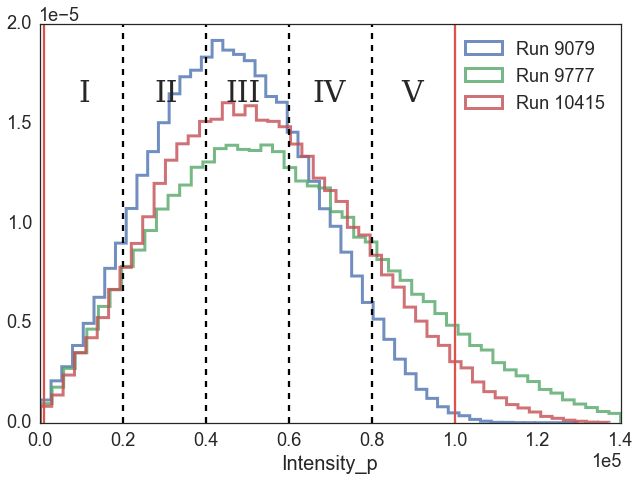

In [10]:
# Plot intensity distributions for three runs of Roadset 57
sns.distplot(intensity_df1['Intensity_p'], kde=False, norm_hist=True,
             label="Run 9079", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
sns.distplot(intensity_df2['Intensity_p'], kde=False, norm_hist=True,
             label="Run 9777", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
sns.distplot(intensity_df3['Intensity_p'], kde=False, norm_hist=True,
                  label="Run 10415", hist_kws={'histtype':'step', 'lw': 3, 'alpha': 0.8})
plt.legend(loc='best')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Plot intensity region dividers
c1 = sns.xkcd_rgb['pale red']
plt.vlines(1000, 0, 2e-5, color=c1, linestyles='-')
plt.vlines(20000, 0, 2e-5,  color='black', linestyles='--')
plt.vlines(40000, 0, 2e-5, color='black', linestyles='--')
plt.vlines(60000, 0, 2e-5, color='black', linestyles='--')
plt.vlines(80000, 0, 2e-5, color='black', linestyles='--')
plt.vlines(100000, 0, 2e-5, color=c1, linestyles='-')
plt.ylim([0,2e-5])

# Label regions
plt.text(9500, 1.61e-5, "I", size=30, fontdict={'family': 'serif'})
plt.text(28000, 1.61e-5, "II", size=30, fontdict={'family': 'serif'})
plt.text(45000, 1.61e-5, "III", size=30, fontdict={'family': 'serif'})
plt.text(66000, 1.61e-5, "IV", size=30, fontdict={'family': 'serif'})
plt.text(87000, 1.61e-5, "V", size=30, fontdict={'family': 'serif'})

plt.savefig("figures/Intensity_Regions.eps")

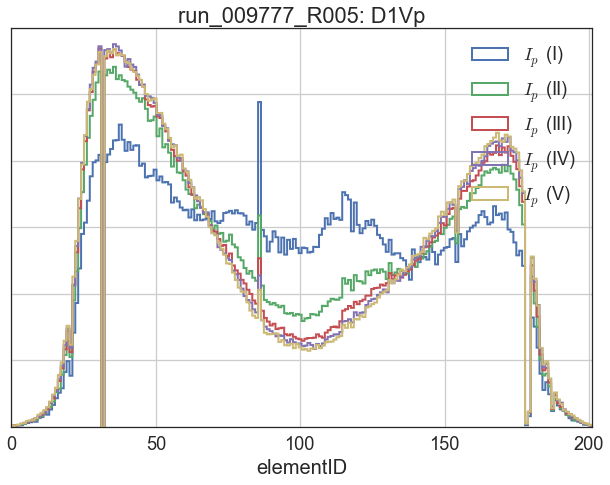

In [12]:
detector = "D1Vp"
ranges = ([1000,20000], [20000, 40000], [40000, 60000],
          [60000, 80000], [80000, 100000])
wiremap_var_int('run_009777_R005', server, detector, ranges,
                from_db=False, normed=True)
#wiremap_var_int('run_009777_R005', server, detector, ranges,
#                from_db=False, normed=False)

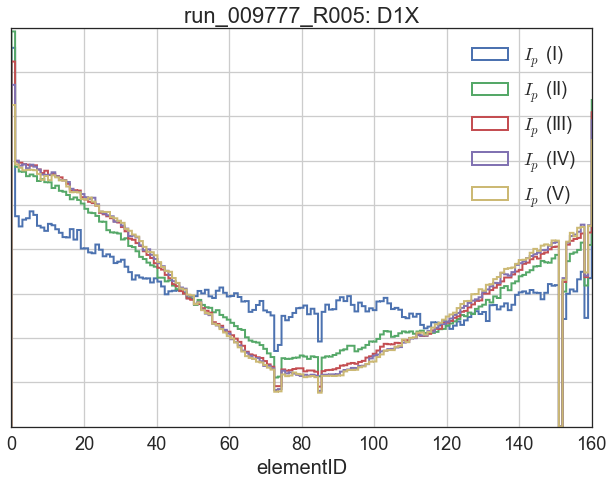

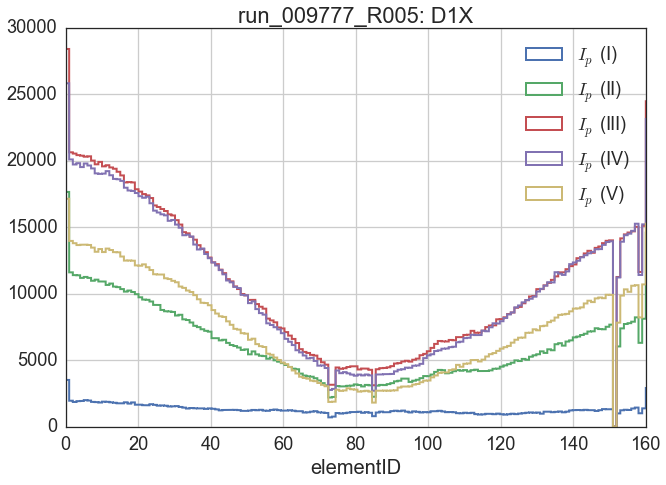

In [9]:
detector = "D1X"
ranges = ([1000,20000], [20000, 40000], [40000, 60000],
          [60000, 80000], [80000, 100000])
wiremap_var_int('run_009777_R005', server, detector, ranges,
                from_db=False, normed=True)
wiremap_var_int('run_009777_R005', server, detector, ranges,
                from_db=False, normed=False)

In [14]:
def kHit_wiremap_var_int(run, server, detector, ranges,
                         from_db=False, normed=True, kHit=False):
    # Fetch elementID's for a given intensity region
    # and a given detector
    
    df_list = []
    if from_db:
        
        track_query = """
                      SELECT DISTINCT trackID
                      FROM kTrack 
                      WHERE numHits > 14 AND
                            chisq/(numHits - 5) < 5 AND
                            z0 BETWEEN -400 AND 200 AND
                            roadID != 0 AND
                            (numHits = 18 OR pz1 > 18)
                      """
        track_list = exec_query(track_query, server, run).trackID.values
        if len(track_list)==0:
            print "No good tracks found. Exiting..."
            return None
        query = """
                SELECT elementID
                FROM kHit k
                    INNER JOIN QIE q USING(eventID)
                    INNER JOIN Spill s ON k.spillID = s.spillID
                WHERE Intensity_p BETWEEN %d AND %d AND
                    detectorName='%s' AND
                    s.dataQuality=0 AND
                    trackID IN ("""
        for track in track_list:
            query += ("%d," % track)
        query = query[:-1] + ")"
        # Read out from DB and write to file
        for int_range in ranges:
            df = exec_query(query % (int_range[0], int_range[1],
                                     detector), server, run)
            df_list.append(df)
            df.to_csv('data/%s_kHit_%s_%d_%d_int.csv' % (run, detector,
                                                    int_range[0],
                                                    int_range[1]))
    else:
        try:
            for int_range in ranges:
                df = pd.read_csv('data/%s_kHit_%s_%d_%d_int.csv' % 
                                 (run, detector, int_range[0],
                                  int_range[1]),
                                 index_col='Unnamed: 0')
                df_list.append(df)
        except:
            print "Files may not exist. Aborting..."
            return None
    
    wiremap(df_list, ranges, run, detector, normed=normed, kHit=True)
    
    return None

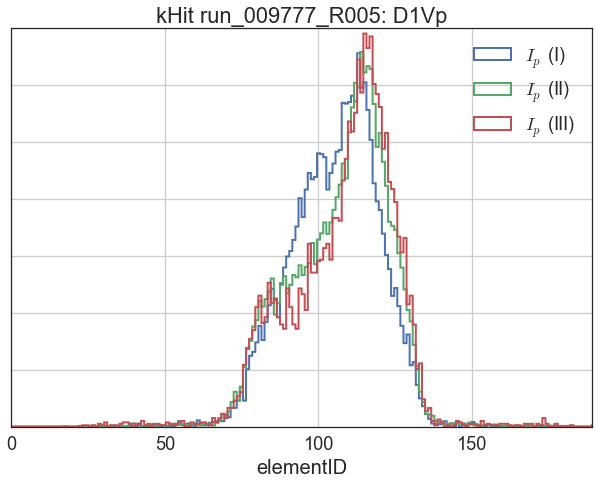

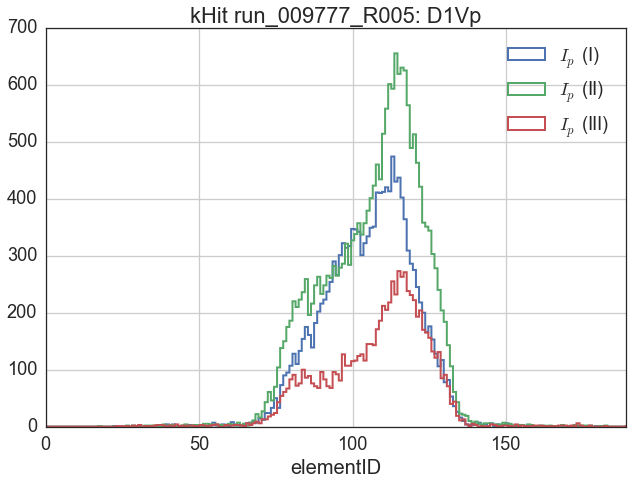

In [38]:
detector = "D1Vp"
ranges = ([1000,33333], [33333,66666], [66666,100000])
kHit_wiremap_var_int('run_009777_R005', server, detector,
                     ranges, from_db=False, normed=True)
kHit_wiremap_var_int('run_009777_R005', server, detector,
                     ranges, from_db=False, normed=False)

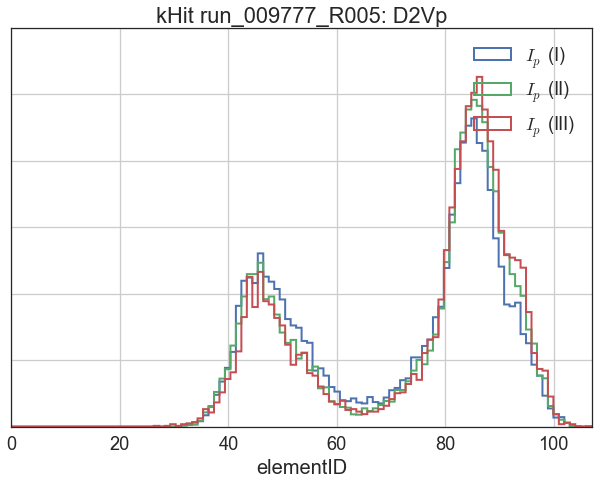

In [16]:
detector = "D2Vp"
ranges = ([1000,33333], [33333,66666], [66666,100000])
kHit_wiremap_var_int('run_009777_R005', server, detector,
                     ranges, from_db=False, normed=True)
#kHit_wiremap_var_int('run_009777_R005', server, detector,
#                     ranges, from_db=False, normed=False)

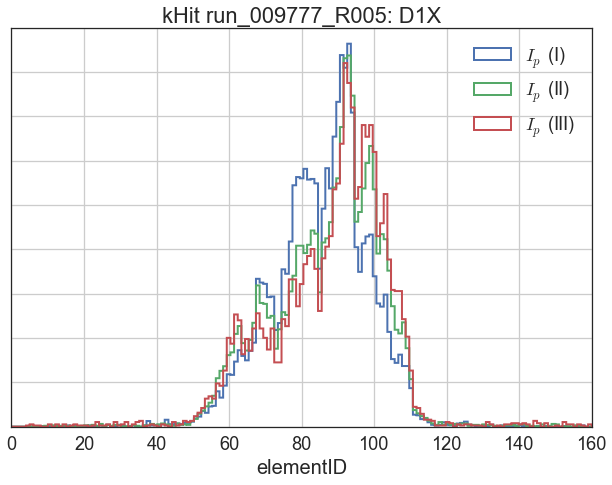

In [17]:
detector = "D1X"
ranges = ([1000,33333], [33333,66666], [66666,100000])
kHit_wiremap_var_int('run_009777_R005', server, detector,
                     ranges, from_db=False, normed=True)
#kHit_wiremap_var_int('run_009777_R005', server, detector,
#                     ranges, from_db=False, normed=False)

## A look at a Random RF Run

In [6]:
detector = "D1X"
ranges = ([1000, 33333], [33333,66666], [66666,100000])
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=True)

NameError: name 'wiremap_var_int' is not defined

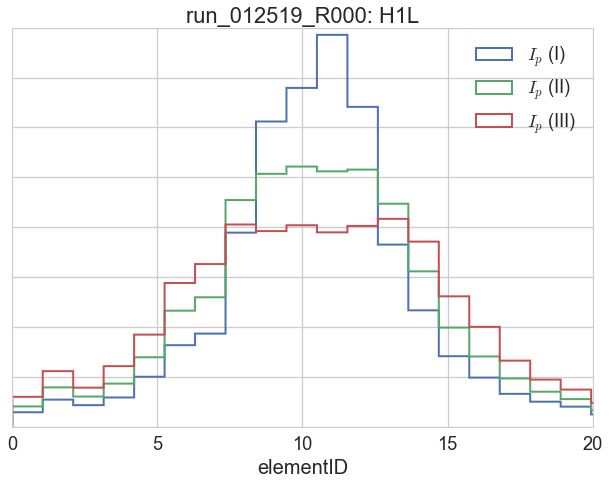

In [15]:
detector = "H1L"
ranges = ([1000, 33333], [33333,66666], [66666,100000])
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=True)

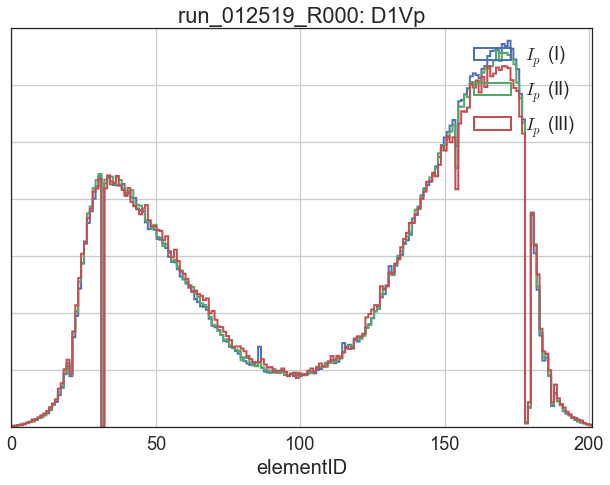

In [19]:
detector = "D1Vp"
ranges = ([1000, 33333], [33333,66666], [66666,100000])
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=True)
#wiremap_var_int('run_012519_R000', server, detector, ranges, from_db=False, normed=False)

In [20]:
query = """SELECT D1, D2, D3, Intensity_p
           FROM QIE q INNER JOIN Occupancy o USING(eventID)
           WHERE Intensity_p BETWEEN 1000 AND 100000
           """
random_rf_df = exec_query(query, server, 'run_012519_R000')

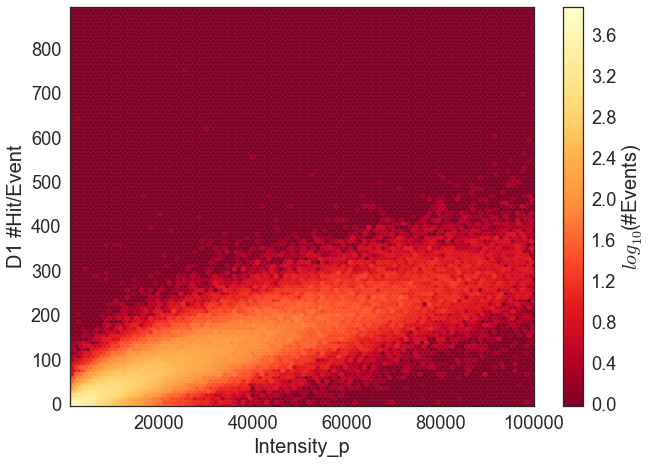

In [21]:
plt.hexbin(random_rf_df.Intensity_p,
           random_rf_df.D1,
           bins='log',
           cmap=plt.cm.YlOrRd_r)
plt.ylabel('D1 #Hit/Event')
plt.xlabel('Intensity_p')
cb = plt.colorbar()
cb.set_label(r'$log_{10}$(#Events)')

In [22]:
query = """SELECT D1, D2, D3, Intensity_p
           FROM QIE q INNER JOIN Occupancy o USING(eventID)
               INNER JOIN Spill s ON q.spillID = s.spillID
           WHERE s.dataQuality = 0 AND
               Intensity_p BETWEEN 1000 AND 100000
           """

In [23]:
df = exec_query(query, server, 'run_009777_R005')

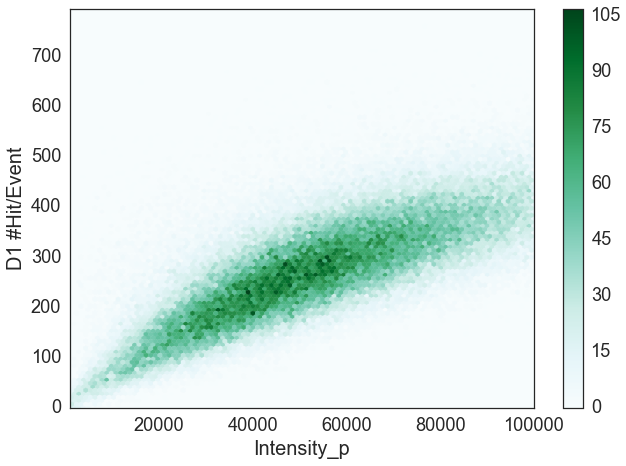

In [24]:
df.plot(x='Intensity_p', y='D1', kind='hexbin', sharex=False)
plt.ylabel('D1 #Hit/Event')

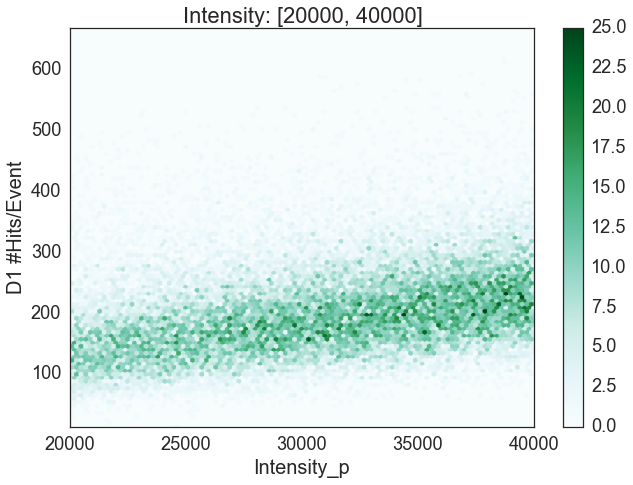

In [25]:
intensity = [20000, 40000]
(df.query('Intensity_p > @intensity[0] and Intensity_p < @intensity[1]')
   .plot(x='Intensity_p', y='D1', kind='hexbin', sharex=False))
plt.ylabel('D1 #Hits/Event')
plt.title('Intensity: [%d, %d]' % (intensity[0], intensity[1]))

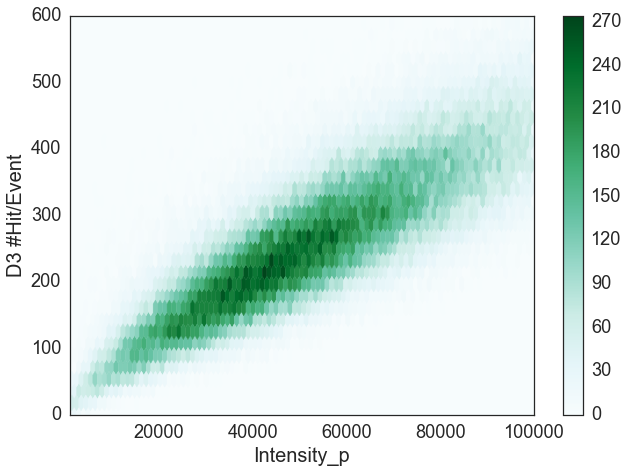

In [26]:
df.plot(x='Intensity_p', y='D3', kind='hexbin', sharex=False, ylim=[0,600])
plt.ylabel('D3 #Hit/Event')

In [27]:
query = """SELECT eventID, LL, L, C, R, RR, Intensity_p
           FROM user_dannowitz.D1X_Occupancy o
               INNER JOIN QIE q USING(eventID)
               INNER JOIN Spill s on q.spillID=s.spillID
           WHERE s.dataQuality=0 AND
               Intensity_p BETWEEN 1000 AND 100000"""
df2 = exec_query(query, server, 'run_009777_R005')

In [28]:
int_bins = [i*10000.0 for i in range(0,11)]

In [29]:
df2.head()

,eventID,LL,L,C,R,RR,Intensity_p
0,1,23,10,3,7,16,72971.253593
1,2,10,4,2,5,9,28044.953997
2,3,13,5,2,12,8,87037.647945
3,4,18,18,4,13,12,94257.515162
4,5,24,16,6,20,22,81700.321559


In [30]:
group_cols = ['LL', 'L', 'C', 'R', 'RR', 'Intensity_p']
groups = df2[group_cols].groupby(by=pd.cut(df2['Intensity_p'], int_bins))

In [31]:
from uncertainties import unumpy as unp
means_df = groups[group_cols].mean()
std_dev_df = groups[group_cols].std()
means_df = pd.DataFrame(unp.uarray(means_df, std_dev_df),
                        columns=means_df.columns,
                        index=means_df.index)

In [32]:
means_df.head()

,LL,L,C,R,RR,Intensity_p
Intensity_p,,,,,,
"(0, 10000]",3.2+/-2.7,4+/-5,4+/-4,3+/-4,3.2+/-2.6,(6.5+/-2.3)e+03
"(10000, 20000]",6+/-4,5+/-4,4+/-4,4+/-4,5.1+/-3.2,(1.55+/-0.28)e+04
"(20000, 30000]",9+/-4,7+/-5,4+/-4,5+/-4,7.1+/-3.5,(2.53+/-0.29)e+04
"(30000, 40000]",12+/-5,8+/-4,4.4+/-3.5,6+/-4,9+/-4,(3.52+/-0.29)e+04
"(40000, 50000]",14+/-5,9+/-4,4.6+/-3.5,7+/-4,10+/-4,(4.50+/-0.29)e+04


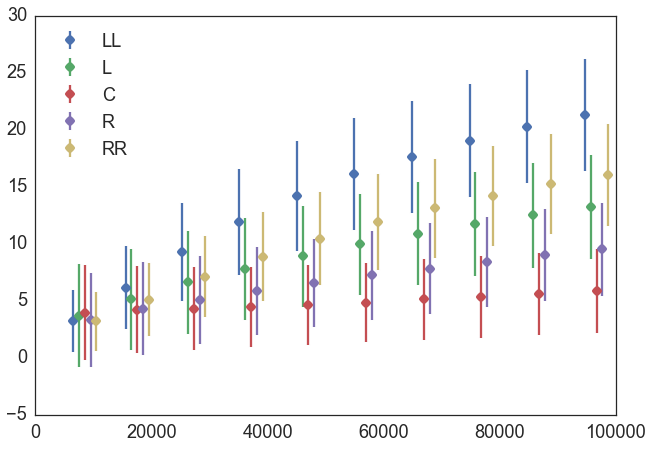

In [33]:
offset = 0.0
for val in ['LL', 'L', 'C', 'R', 'RR']:
    plt.errorbar(unp.nominal_values(means_df['Intensity_p']) + offset,
                 unp.nominal_values(means_df[val]),
                 yerr=unp.std_devs(means_df[val]),
                 label=val, fmt='o')
    offset += 1000.0
    
plt.legend(loc='best')

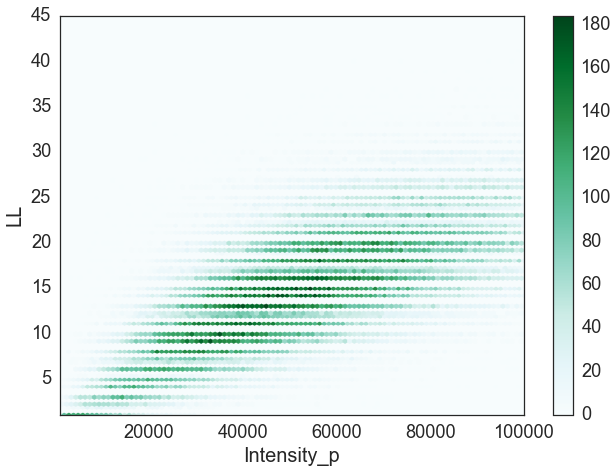

In [34]:
df2.plot(x='Intensity_p', y='LL', kind='hexbin', sharex=False)

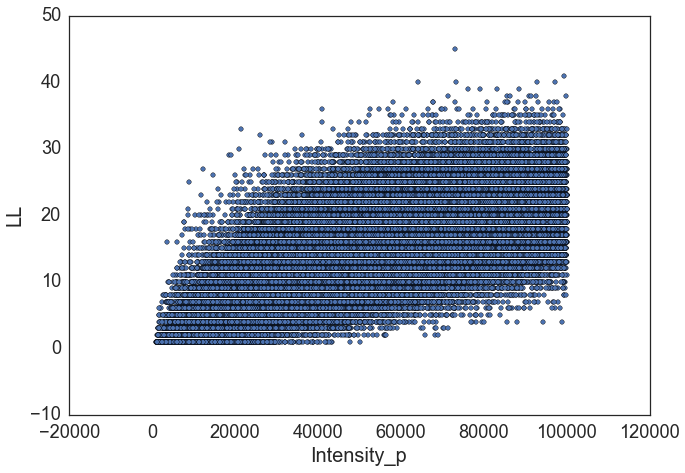

In [35]:
df2.plot(x='Intensity_p', y='LL', kind='scatter', sharex=False)

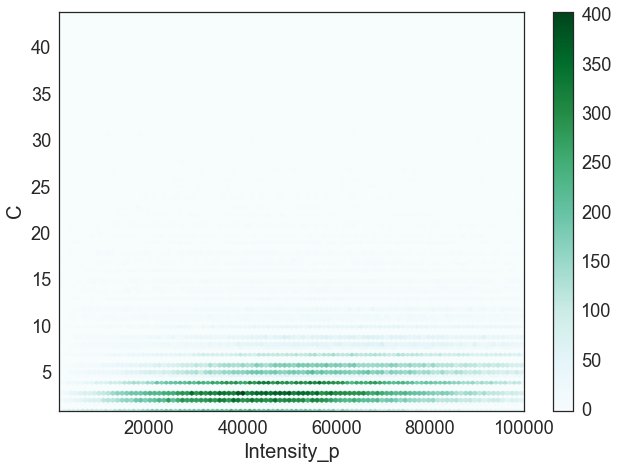

In [36]:
df2.plot(x='Intensity_p', y='C', kind='hexbin', sharex=False)

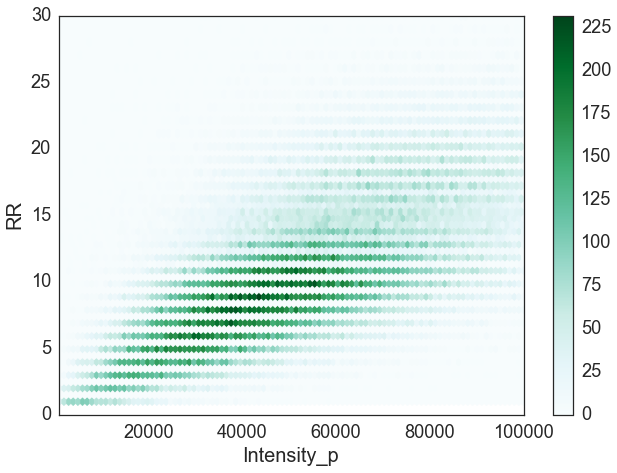

In [37]:
df2.plot(x='Intensity_p', y='RR', kind='hexbin', sharex=False, ylim=[0,30])